In [1]:
# Минимальная совместимость с 2.7
from __future__ import division, print_function
# Отключение предупрждений Anaconda
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# названия признаков из данных
feature_names = [
    'account_status',
    'duration',
    'credit_history',
    'purpose',
    'credit_amount',
    'savings_account',
    'present_employment_since',
    'installment_rate_in_percentage_of_disposable_income',
    'personal_status_and_sex',
    'debtors/guarantors',
    'present_residence_since',
    'property',
    'age_in_years',
    'other_installment_plans',
    'housing',
    'number_of_existing_credits_at_this_bank',
    'job',
    'number_of_people_being_liable_to_provide_maintenance_for',
    'telephone',
    'foreign_worker'
]

In [4]:
data = pd.read_csv('german.csv', index_col=0, names=feature_names + ['target'], header=0)
target = data['target']
data = data.drop('target', axis=1)

In [5]:
data.head()

,account_status,duration,credit_history,purpose,credit_amount,savings_account,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,debtors/guarantors,present_residence_since,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker
1,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,good,A192,A201
2,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,good,A191,A201
3,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,bad,A191,A201
4,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,bad,A191,A201
5,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,bad,A191,A201


### Кодирование вручную.
оказалось бессмысленным - поставленные вручную значения не улучшили читаемость построенного дерева

In [6]:
encoder = {
    'account_status' : {
        'A11' : 0,   #... < 0 DM
        'A12' : 2,   #<= ... < 200 DM
        'A13' : 4,   #... >= 200 DM / salary assignments for at least 1 year
        'A14' : -1,  #no checking account 
    },
    'credit_history' : {
        'A30' : 1,   #no credits taken/ all credits paid back duly
        'A31' : 10,  #all credits at this bank paid back duly
        'A32' : 0,   #existing credits paid back duly till now
        'A33' : -10, #delay in paying off in the past
        'A34' : -50, #critical account/ other credits existing (not at this bank)
    },
    'purpose' : {
        'A40' : 1,   #car (new)
        'A41' : 2,   #car (used)
        'A42' : 3,   #furniture/equipment
        'A43' : 4,   #radio/television
        'A44' : 5,   #domestic appliances
        'A45' : 6,   #repairs
        'A46' : 7,   #education
        'A47' : 8,   #(vacation - does not exist?)
        'A48' : 9,   #retraining
        'A49' : 10,  #business
        'A410' : 0,  #others
    },
    'savings_account' : {
        'A61' : 1,   #... < 100 DM
        'A62' : 5,   #100 <= ... < 500 DM
        'A63' : 10,  #500 <= ... < 1000 DM
        'A64' : 100, #.. >= 1000 DM
        'A65' : 0,   #unknown/ no savings account 
    },
    'present_employment_since' : {
        'A71' : 0,   #unemployed
        'A72' : 1,   #... < 1 year
        'A73' : 4,   #1 <= ... < 4 years
        'A74' : 7,   #4 <= ... < 7 years
        'A75' : 10,  #.. >= 7 years 
    },
    'personal_status_and_sex' : {
        'A91' : 2,   #male : divorced/separated
        'A92' : 10,  #female : divorced/separated/married
        'A93' : 1,   #male : single
        'A94' : 3,   #male : married/widowed
        'A95' : 11,  #female : single 
    },  
    'debtors/guarantors' : {
        'A101' : 0,  #none
        'A102' : 1,  #co-applicant
        'A103' : 2,  #guarantor 
    },
    'property' : {
        'A121' : 1,  #real estate
        'A122' : 2,  #if not A121 : building society savings agreement/ life insurance
        'A123' : 3,  #if not A121/A122 : car or other, not in attribute 6
        'A124' : 0,  #unknown / no property 
    },
    'other_installment_plans' : {
        'A141' : 1,  #bank
        'A142' : 2,  #stores
        'A143' : 0,  #none 
    },
    'housing' : {
        'A151' : 1,  # rent
        'A152' : 2,  # own
        'A153' : 0,  # for free
    },    
    'job' : {
        'A171' : 1,  #unemployed/ unskilled - non-resident
        'A172' : 2,  #unskilled - resident
        'A173' : 3,  #skilled employee / official
        'A174' : 4,  #management/ self-employed/highly qualified employee/ officer 
    },    
    'telephone' : {
        'A191': False,
        'A192': True,
    },
    'foreign_worker' : {
        'A201': True,
        'A202': False,
    },
    'number_of_people_being_liable_to_provide_maintenance_for' : {
        'bad' : 0,
        'good': 1,
    }
}

In [8]:
# Перекодирование
for key, mapper in encoder.items():
    data[key] = data[key].apply(lambda x: mapper[x])
data.head()

,account_status,duration,credit_history,purpose,credit_amount,savings_account,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,debtors/guarantors,present_residence_since,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker
1,0,6,-50,4,1169,0,10,4,1,0,4,1,67,0,2,2,3,1,True,True
2,2,48,0,4,5951,1,4,2,10,0,2,1,22,0,2,1,3,1,False,True
3,-1,12,-50,7,2096,1,7,2,1,0,3,1,49,0,2,1,2,0,False,True
4,0,42,0,3,7882,1,7,2,1,2,4,2,45,0,0,1,3,0,False,True
5,0,24,-10,1,4870,1,4,3,1,0,4,0,53,0,0,2,3,0,False,True


## После подготовки данных обучим и посмотрим дерево:

In [9]:

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(data, target)

export_graphviz(clf, feature_names=feature_names,class_names=['Good', 'Bad'], out_file='tree.dot', filled=True)
!dot -Tpng 'tree.dot' -o 'tree.png'

<img src='tree.png'>

## Интерпртация:
1) самый важный признак - наличие счета до момент обращения за кредитом.

2) наличие сбережений - плохо для получения кредите (правая ветвь)

3) отсутствие кредитной истории (или ее идеальность) хуже, чем пара просрочек (третий справа синий исход)

4) возраст выше 30 лет чаще всего позволяет получить кредит сразу (205 против 9, левая ветвь. хотя молодым тоже часто дают кредит)

и т.д.

## Подберем оптимальную глубину дерева

In [28]:
metric = 'precision'
depth_list = list(range(1, 31))

In [29]:
GS_DT_depth = GridSearchCV(DecisionTreeClassifier(random_state=0),
                           n_jobs=-1,
                           scoring=metric,
                           param_grid={'max_depth': depth_list},
                          )

In [30]:
GS_DT_depth.fit(data, target)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

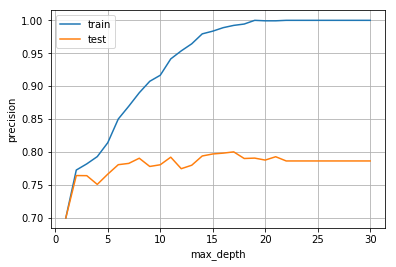

{'max_depth': 17}
Best_test_score: 0.800
Metric used: precision


In [31]:
plt.plot(depth_list, GS_DT_depth.cv_results_['mean_train_score'], label='train')
plt.plot(depth_list, GS_DT_depth.cv_results_['mean_test_score'], label='test')
plt.legend(loc='best')
plt.ylabel(metric)
plt.xlabel('max_depth')
plt.grid()
plt.show()

print (GS_DT_depth.best_params_)
print ('Best_test_score: %.3f' %round(GS_DT_depth.best_score_, 3))
print ('Metric used: %s' %metric)

Для этой метрики получен красивый график